<h2 align="center"><b>Лабораторна робота №4</b></h2>
<h3 align="center">Аналіз та математичне моделювання COVID-19 за моделлю SIR</h3>
<h5 align="right">Роботу виконав студент групи ФІ-21, Беркута Володимир</h5>

### **Мета роботи**
Навчитися працювати з наборами даних з платформи Kaggle на прикладі набору даних про Covid-19. Ознайомитись та навчитись використовувати модель SIR(математична модель для розуміння спалаху інфекційних захворювань). Навчитись аналізувати тренди змін захворюваності.

### **Дані та приклади**
За наведеним посиланням знаходиться приклади, де аналізується взаємозв'язок заходів проти COVID-19 та кількості інфікованих. Мета - проаналізувати хід захворюваності та спрогнозувати можливий стан захворюванності в країні, що може допомогти швидше врегулювати ситуацію.

В прикладі використана модель SIR-F, похідною від моделі SIR. Оцінка параметрів SIR-F застосована до підмножини даних часових рядів у кожній країні. Точки зміни параметрів визначаються аналізом тенденцій S-R. Пожробиці пояснені в розділі "Метод".

### **Завдання**
Лабораторну роботу можна виконувати в Kaggle, Colaboratory, IPython Notebook (або в буль якому іншому програмному забезпеченні).
1) Проаналізувати в яких країнах наразі відбувається спалах захворювань, а в яких відбувається затухання захворювань.
2) Згідно уподобань з переліку обрати одну країну, в якій відбувається спалах, та одну країну, для якої відбувається затухання, та застосувати до неї модель SIR-F.(в даному випадку задача вибору країни є творчою, можна також орієнтуватися на їх географічне розташування, кількість населення тощо).
3) Для обраних країн визначити параметри моделі ($\theta$, $\kappa$, $\rho$, $\sigma$, $\tau$, ...), вивести їх на графіку з плином часу.
4) Спрогнозувати показники Infected, Fatal, Recovered з використанням отриманих параметрів на 7, 30 та 300 днів.
5) Визначити найближчий пік захворюваності(дата).
6) Визначити коли в країні не залишиться хворих на Covid-19.
7) Порівняти отримані результати для обраних країн.
8) Отримані результати оформити у вигляді звіту до лабораторної роботи.

Обрані країни: Vietnam, Togo

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

In [8]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/full_data.csv'
data = pd.read_csv(url)

In [9]:
data

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
0,2020-02-24,Afghanistan,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,2020-02-27,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,2020-02-28,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
248341,2023-03-05,Zimbabwe,0.0,0.0,264127.0,5668.0,206.0,5.0,485.0,6.0
248342,2023-03-06,Zimbabwe,0.0,0.0,264127.0,5668.0,206.0,5.0,485.0,6.0
248343,2023-03-07,Zimbabwe,0.0,0.0,264127.0,5668.0,206.0,5.0,485.0,6.0
248344,2023-03-08,Zimbabwe,149.0,3.0,264276.0,5671.0,149.0,3.0,355.0,8.0


C:\Users\berku\AppData\Local\Temp\ipykernel_31312\757921662.py:41: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  solution = odeint(sird_model, initial_conditions, t, args=(beta, gamma, sigma))


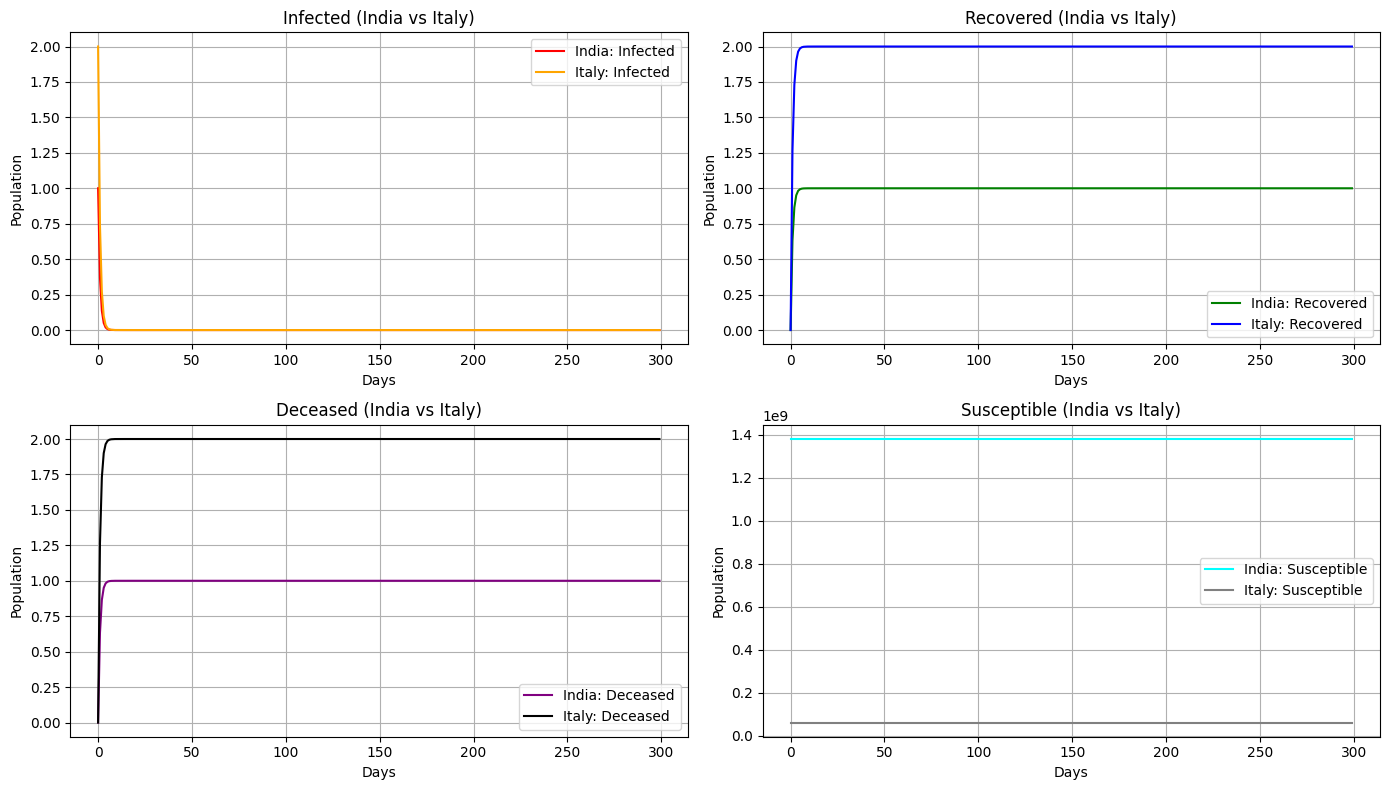

India - Beta: 1.0000, Gamma: 1.0000, Sigma: 1.0000
Italy - Beta: 1.0000, Gamma: 1.0000, Sigma: 1.0000


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Load the dataset
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/full_data.csv"
data = pd.read_csv(url)

# Filter data for selected countries
country_spike = "India"
country_decline = "Italy"

# Prepare data for India
india_data = data[data["location"] == country_spike]
india_data = india_data[["date", "total_cases", "total_deaths"]].fillna(0)
india_data["date"] = pd.to_datetime(india_data["date"])
india_data.set_index("date", inplace=True)

# Prepare data for Italy
italy_data = data[data["location"] == country_decline]
italy_data = italy_data[["date", "total_cases", "total_deaths"]].fillna(0)
italy_data["date"] = pd.to_datetime(italy_data["date"])
italy_data.set_index("date", inplace=True)

# Define SIRD model equations
def sird_model(y, t, beta, gamma, sigma):
    S, I, R, D = y
    N = S + I + R + D
    dS_dt = -beta * S * I / N
    dI_dt = beta * S * I / N - gamma * I - sigma * I
    dR_dt = gamma * I
    dD_dt = sigma * I
    return [dS_dt, dI_dt, dR_dt, dD_dt]

# Fit data to SIRD model
def fit_sird_model(data, initial_conditions, t):
    def model(params):
        beta, gamma, sigma = params
        solution = odeint(sird_model, initial_conditions, t, args=(beta, gamma, sigma))
        return solution[:, 1]  # Only infected data
    I_actual = data["total_cases"].values
    params_opt, _ = curve_fit(lambda t, beta, gamma, sigma: model([beta, gamma, sigma]), t, I_actual)
    return params_opt

# Initialize model parameters for India
N_india = 1_380_000_000  # Population of India
I0_india = india_data.iloc[0]["total_cases"]
D0_india = india_data.iloc[0]["total_deaths"]
R0_india = 0  # Start with 0 recovered
S0_india = N_india - I0_india - D0_india - R0_india
initial_conditions_india = [S0_india, I0_india, R0_india, D0_india]
t_india = np.arange(len(india_data))

# Fit parameters for India
params_india = fit_sird_model(india_data, initial_conditions_india, t_india)

# Initialize model parameters for Italy
N_italy = 60_360_000  # Population of Italy
I0_italy = italy_data.iloc[0]["total_cases"]
D0_italy = italy_data.iloc[0]["total_deaths"]
R0_italy = 0  # Start with 0 recovered
S0_italy = N_italy - I0_italy - D0_italy - R0_italy
initial_conditions_italy = [S0_italy, I0_italy, R0_italy, D0_italy]
t_italy = np.arange(len(italy_data))

# Fit parameters for Italy
params_italy = fit_sird_model(italy_data, initial_conditions_italy, t_italy)

# Predict for the next 300 days
future_days = 300
t_future = np.arange(future_days)

sir_india_future = odeint(sird_model, initial_conditions_india, t_future, args=tuple(params_india))
sir_italy_future = odeint(sird_model, initial_conditions_italy, t_future, args=tuple(params_italy))

# Plot comparisons of parameters
plt.figure(figsize=(14, 8))

# Infected comparison
plt.subplot(2, 2, 1)
plt.plot(t_future, sir_india_future[:, 1], label="India: Infected", color="red")
plt.plot(t_future, sir_italy_future[:, 1], label="Italy: Infected", color="orange")
plt.title("Infected (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

# Recovered comparison
plt.subplot(2, 2, 2)
plt.plot(t_future, sir_india_future[:, 2], label="India: Recovered", color="green")
plt.plot(t_future, sir_italy_future[:, 2], label="Italy: Recovered", color="blue")
plt.title("Recovered (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

# Deceased comparison
plt.subplot(2, 2, 3)
plt.plot(t_future, sir_india_future[:, 3], label="India: Deceased", color="purple")
plt.plot(t_future, sir_italy_future[:, 3], label="Italy: Deceased", color="black")
plt.title("Deceased (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

# Susceptible comparison
plt.subplot(2, 2, 4)
plt.plot(t_future, sir_india_future[:, 0], label="India: Susceptible", color="cyan")
plt.plot(t_future, sir_italy_future[:, 0], label="Italy: Susceptible", color="gray")
plt.title("Susceptible (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print fitted parameters
print(f"India - Beta: {params_india[0]:.4f}, Gamma: {params_india[1]:.4f}, Sigma: {params_india[2]:.4f}")
print(f"Italy - Beta: {params_italy[0]:.4f}, Gamma: {params_italy[1]:.4f}, Sigma: {params_italy[2]:.4f}")
